<a href="https://colab.research.google.com/github/mobinshd/m4/blob/master/Copy_of_new_book_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Library

In [3]:
!pip install python-docx
!pip install parsivar
!wget https://www.dropbox.com/s/tlyvnzv1ha9y1kl/spell.zip
!pip install langdetect

     |████████████████████████████████| 5.5MB 18.6MB/s 
  Created wheel for python-docx: filename=python_docx-0.8.10-cp37-none-any.whl size=184491 sha256=dd9f50d69061623d99015f0db419fcf6d961d8a86d3d0a82023fc7992d6a175a
  Stored in directory: /root/.cache/pip/wheels/18/0b/a0/1dd62ff812c857c9e487f27d80d53d2b40531bec1acecfa47b
Successfully built python-docx
     |████████████████████████████████| 36.2MB 81kB/s 
     |████████████████████████████████| 1.5MB 47.9MB/s 
  Created wheel for parsivar: filename=parsivar-0.2.3-cp37-none-any.whl size=36492958 sha256=37b48afe0299cb44758dfe411d43125dce97261399ff3595ae503776f0932e77
  Stored in directory: /root/.cache/pip/wheels/b4/56/cd/29a045228c81c482429c711646af316ada1218f3029edce37c
  Created wheel for nltk: filename=nltk-3.4.5-cp37-none-any.whl size=1449906 sha256=536cdc99cc49fef14709a5985b46ce7cd263d6938a3cfeb7e6d4a0789825f660
  Stored in directory: /root/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfull

In [5]:
!python --version

Python 3.7.10


In [ ]:

!unzip spell.zip


Archive:  spell.zip
  inflating: mybigram_lm.pckl        
  inflating: onegram.pckl            


In [ ]:
!mkdir /usr/local/lib/python3.7/dist-packages/parsivar/resource/spell
!cp onegram.pckl /usr/local/lib/python3.7/dist-packages/parsivar/resource/spell/
!cp mybigram_lm.pckl /usr/local/lib/python3.7/dist-packages/parsivar/resource/spell/

In [ ]:
import sqlalchemy  
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from docx import Document
import os
import pandas as pd
from parsivar import Normalizer
from parsivar import Tokenizer
from parsivar import FindStems
from parsivar import SpellCheck
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
import numpy as np
from langdetect import detect
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import sklearn.metrics as metrics
import sys
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sys import getsizeof
import gc

# 1-Initial Dataset


In [ ]:
df = pd.DataFrame(data={'filename': [], 'content': [],'label': [],'labelfarsi':[]})
for dirName, subDirList, fileList in os.walk('/content/drive/MyDrive/books/',topdown=True):
    print(dirName)
    print(subDirList)
    print(fileList)
    for file in fileList:
          filename,extension = os.path.splitext(file)             
          x= dirName.split('-',1)
          d=Document(dirName+'/'+filename+'.docx')
          text = ''
          for p in d.paragraphs:
            text += p.text
          df=df.append(pd.DataFrame({'filename':[filename],
                              'content':[text] ,
                              'label': [x[0].split('/')[-1]] ,
                              'labelfarsi':[ x[1]],
                              'paragrapghs_length':[len(d.paragraphs)],
                              'content_length':[len(text)]}),ignore_index=True)
    gc.collect()
df

/content/drive/MyDrive/books/
['C', 'A', 'S', 'Z', 'B', 'M']
[]
/content/drive/MyDrive/books/C
['CT- علوم وابسته به تاریخ - سرگذشتنامه', 'CB- علوم وابسته به تاریخ - تاریخ تمدن']
[]
/content/drive/MyDrive/books/C/CT- علوم وابسته به تاریخ - سرگذشتنامه
[]
['100798586.docx', '102602362.docx', '102470018.docx', '104731826.docx', '104342650.docx', '104694777.docx', '103887676.docx', '105538582.docx', '108256379.docx', '111919643.docx', '111976617.docx', '113222104.docx', '113466624.docx', '112779318.docx', '113093403.docx', '114218465.docx', '112702866.docx', '113232823.docx', '113153463.docx', '113781134.docx', '114749428.docx', '114352696.docx', '115674690.docx', '115111401.docx', '115625446.docx', '115938537.docx', '116116234.docx', '116645470.docx', '116538081.docx', '116287161.docx', '117397342.docx', '118596582.docx', '118597652.docx', '118298920.docx', '118595829.docx', '118593953.docx', '118321951.docx', '118599289.docx', '118938193.docx', '118665396.docx', '118665781.docx', '1187352

,filename,content,label,labelfarsi,paragrapghs_length,content_length
0,100798586,\n\nسرشناسه: عطا، نصیردفتری، ۱۳۰۹-مقدمه‌نویس: ...,CT,علوم وابسته به تاریخ - سرگذشتنامه,202.0,32792.0
1,102602362,افرهنگ چهره‌های تاریخی ایرانجلد اولتألیف و تدو...,CT,علوم وابسته به تاریخ - سرگذشتنامه,438.0,37093.0
2,102470018,\n\nشناسنامه کتاب:نام کتاب: خوشه‌چینی از بزرگا...,CT,علوم وابسته به تاریخ - سرگذشتنامه,271.0,23330.0
3,104731826,\n\n\nنام‌آوران تاریخدانشمندان و مخترعان، شاعر...,CT,علوم وابسته به تاریخ - سرگذشتنامه,243.0,37642.0
4,104342650,یاد داشت های پروانهپروانهجلالی پور\nیاد داشت ه...,CT,علوم وابسته به تاریخ - سرگذشتنامه,97.0,3259.0
...,...,...,...,...,...,...
6812,100441660,\n\n\n\nمؤلفان: کیوان جعفری نژاد - پرند زهدی\n...,MT,موسیقی - آموزش و مطالعه موسيقي,637.0,22007.0
6813,102254788,نت گرد و سکوت گردگام به گام با آوانت های G که ...,MT,موسیقی - آموزش و مطالعه موسيقي,252.0,10962.0
6814,101012347,وی حرابده قطعه برای گیتارپراولوف کیندگرنفرزاد ...,MT,موسیقی - آموزش و مطالعه موسيقي,274.0,5148.0
6815,101811203,دانشمندروش آموزش گیتار کلاسیک\nدانشمندروش آموز...,MT,موسیقی - آموزش و مطالعه موسيقي,289.0,31757.0


# 2-Data Cleaning 

**Data cleaning function**

In [ ]:

def ShowContent_doc(content):
    print(content)
    print('_________________________________________________________')

####################################################

def LanguageDetection_doc(doc):
  rng=3000 #at least lenght of str

  lan=detect(doc.content[0:rng])
  return lan 


**removing empty docs**

In [ ]:
#بعضی اسناد خالی هستند و باید حذف شوند
t=df.loc[(df.paragrapghs_length <50) | (df.content_length<3000)]
df.drop(t.index,inplace=True)
df.reset_index(inplace=True)
df

,index,filename,content,label,labelfarsi,paragrapghs_length,content_length
0,0,100798586,\n\nسرشناسه: عطا، نصیردفتری، ۱۳۰۹-مقدمه‌نویس: ...,CT,علوم وابسته به تاریخ - سرگذشتنامه,202.0,32792.0
1,1,102602362,افرهنگ چهره‌های تاریخی ایرانجلد اولتألیف و تدو...,CT,علوم وابسته به تاریخ - سرگذشتنامه,438.0,37093.0
2,2,102470018,\n\nشناسنامه کتاب:نام کتاب: خوشه‌چینی از بزرگا...,CT,علوم وابسته به تاریخ - سرگذشتنامه,271.0,23330.0
3,3,104731826,\n\n\nنام‌آوران تاریخدانشمندان و مخترعان، شاعر...,CT,علوم وابسته به تاریخ - سرگذشتنامه,243.0,37642.0
4,4,104342650,یاد داشت های پروانهپروانهجلالی پور\nیاد داشت ه...,CT,علوم وابسته به تاریخ - سرگذشتنامه,97.0,3259.0
...,...,...,...,...,...,...,...
6642,6810,102402460,بسم الله الرحمن الرحیم\nبسم الله الرحمن الرحیم...,MT,موسیقی - آموزش و مطالعه موسيقي,74.0,3893.0
6643,6812,100441660,\n\n\n\nمؤلفان: کیوان جعفری نژاد - پرند زهدی\n...,MT,موسیقی - آموزش و مطالعه موسيقي,637.0,22007.0
6644,6813,102254788,نت گرد و سکوت گردگام به گام با آوانت های G که ...,MT,موسیقی - آموزش و مطالعه موسيقي,252.0,10962.0
6645,6814,101012347,وی حرابده قطعه برای گیتارپراولوف کیندگرنفرزاد ...,MT,موسیقی - آموزش و مطالعه موسيقي,274.0,5148.0


**language detection**

In [ ]:
language=[]
for i in range(len(df)):
  language.append( LanguageDetection_doc(df.loc[i]))

df.insert(5,"language",language)
df 

,index,filename,content,label,labelfarsi,language,paragrapghs_length,content_length
0,0,100798586,\n\nسرشناسه: عطا، نصیردفتری، ۱۳۰۹-مقدمه‌نویس: ...,CT,علوم وابسته به تاریخ - سرگذشتنامه,fa,202.0,32792.0
1,1,102602362,افرهنگ چهره‌های تاریخی ایرانجلد اولتألیف و تدو...,CT,علوم وابسته به تاریخ - سرگذشتنامه,fa,438.0,37093.0
2,2,102470018,\n\nشناسنامه کتاب:نام کتاب: خوشه‌چینی از بزرگا...,CT,علوم وابسته به تاریخ - سرگذشتنامه,fa,271.0,23330.0
3,3,104731826,\n\n\nنام‌آوران تاریخدانشمندان و مخترعان، شاعر...,CT,علوم وابسته به تاریخ - سرگذشتنامه,fa,243.0,37642.0
4,4,104342650,یاد داشت های پروانهپروانهجلالی پور\nیاد داشت ه...,CT,علوم وابسته به تاریخ - سرگذشتنامه,fa,97.0,3259.0
...,...,...,...,...,...,...,...,...
6642,6810,102402460,بسم الله الرحمن الرحیم\nبسم الله الرحمن الرحیم...,MT,موسیقی - آموزش و مطالعه موسيقي,fa,74.0,3893.0
6643,6812,100441660,\n\n\n\nمؤلفان: کیوان جعفری نژاد - پرند زهدی\n...,MT,موسیقی - آموزش و مطالعه موسيقي,fa,637.0,22007.0
6644,6813,102254788,نت گرد و سکوت گردگام به گام با آوانت های G که ...,MT,موسیقی - آموزش و مطالعه موسيقي,fa,252.0,10962.0
6645,6814,101012347,وی حرابده قطعه برای گیتارپراولوف کیندگرنفرزاد ...,MT,موسیقی - آموزش و مطالعه موسيقي,fa,274.0,5148.0


**grouping languages**

In [ ]:

df.groupby(['language']).size().reset_index(name='counts')

,language,counts
0,ar,13
1,ca,2
2,de,3
3,en,160
4,es,1
5,fa,6459
6,fr,1
7,it,1
8,so,5
9,tr,1


**none Farsi Detection**

In [ ]:

nonfarsi=df.loc[ (df['language']!='fa') ]
nonfarsi

,index,filename,content,label,labelfarsi,language,paragrapghs_length,content_length
319,319,207781376,EducatedEducated\nEducatedEducated\nEducatedE ...,CT,علوم وابسته به تاریخ - سرگذشتنامه,en,73.0,3476.0
402,402,119959278,unduStrategic\nForesight\nFor Corporate\nand R...,CB,علوم وابسته به تاریخ - تاریخ تمدن,en,229.0,45704.0
414,414,101742772,It's YOUR Future\nIt's YOUR Future\n\nIt'sYOUR...,CB,علوم وابسته به تاریخ - تاریخ تمدن,en,279.0,41157.0
434,434,140634025,Salahaddin KHALILOVPHILO\nSCIENCE\nCU\nTheir P...,CB,علوم وابسته به تاریخ - تاریخ تمدن,en,94.0,14878.0
448,448,159238727,97819\n97819\nScribe Publications\nFUTUREVISIO...,CB,علوم وابسته به تاریخ - تاریخ تمدن,en,113.0,16209.0
...,...,...,...,...,...,...,...,...
6431,6564,83731459,قطعاتی برای پیانو\nایرانی - کلاسیکتهیه و گردآو...,MT,موسیقی - آموزش و مطالعه موسيقي,en,278.0,3261.0
6467,6606,136021619,تصویر تازه(۳۲ قطعه برای هنرجویان دوره متوسطه گ...,MT,موسیقی - آموزش و مطالعه موسيقي,ca,395.0,3502.0
6488,6628,132702832,\n\n\nZarb-avaلری ووازووضی‌قیByHamid Ghanbari\...,MT,موسیقی - آموزش و مطالعه موسيقي,en,465.0,7122.0
6508,6654,129253887,ویلن قرمز\nویلن قرمز\n\nویلن قرمز\nجان کریلیان...,MT,موسیقی - آموزش و مطالعه موسيقي,en,245.0,3046.0


**removing non Farsi Documents**

In [ ]:

df.drop(nonfarsi.index ,inplace=True)
df.reset_index(inplace=True)
df

,level_0,index,filename,content,label,labelfarsi,language,paragrapghs_length,content_length
0,0,0,100798586,\n\nسرشناسه: عطا، نصیردفتری، ۱۳۰۹-مقدمه‌نویس: ...,CT,علوم وابسته به تاریخ - سرگذشتنامه,fa,202.0,32792.0
1,1,1,102602362,افرهنگ چهره‌های تاریخی ایرانجلد اولتألیف و تدو...,CT,علوم وابسته به تاریخ - سرگذشتنامه,fa,438.0,37093.0
2,2,2,102470018,\n\nشناسنامه کتاب:نام کتاب: خوشه‌چینی از بزرگا...,CT,علوم وابسته به تاریخ - سرگذشتنامه,fa,271.0,23330.0
3,3,3,104731826,\n\n\nنام‌آوران تاریخدانشمندان و مخترعان، شاعر...,CT,علوم وابسته به تاریخ - سرگذشتنامه,fa,243.0,37642.0
4,4,4,104342650,یاد داشت های پروانهپروانهجلالی پور\nیاد داشت ه...,CT,علوم وابسته به تاریخ - سرگذشتنامه,fa,97.0,3259.0
...,...,...,...,...,...,...,...,...,...
6454,6642,6810,102402460,بسم الله الرحمن الرحیم\nبسم الله الرحمن الرحیم...,MT,موسیقی - آموزش و مطالعه موسيقي,fa,74.0,3893.0
6455,6643,6812,100441660,\n\n\n\nمؤلفان: کیوان جعفری نژاد - پرند زهدی\n...,MT,موسیقی - آموزش و مطالعه موسيقي,fa,637.0,22007.0
6456,6644,6813,102254788,نت گرد و سکوت گردگام به گام با آوانت های G که ...,MT,موسیقی - آموزش و مطالعه موسيقي,fa,252.0,10962.0
6457,6645,6814,101012347,وی حرابده قطعه برای گیتارپراولوف کیندگرنفرزاد ...,MT,موسیقی - آموزش و مطالعه موسيقي,fa,274.0,5148.0


# 3-Data Analysis

**Number of articles in each category**


In [ ]:
labellist=df.groupby(["label"]).size().reset_index(name='counts')
labellist

,label,counts
0,AG,356
1,B,392
2,BBR,395
3,BD,379
4,BF,377
5,BJ,383
6,BL,395
7,BPB,383
8,CB,238
9,CT,399


**Plot classes**

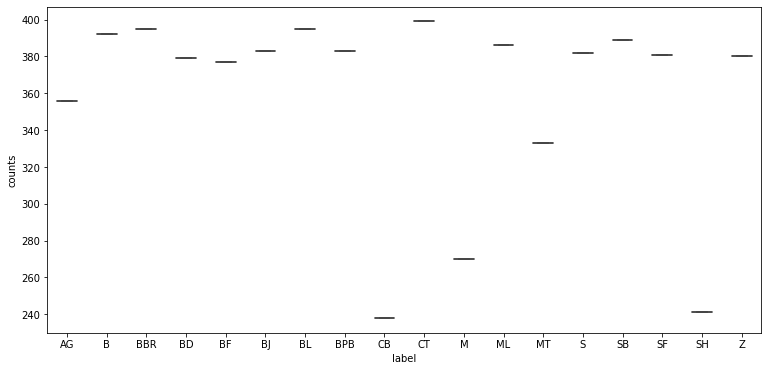

In [ ]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=labellist, x='label', y='counts', width=.5);

# 4-Data Preprocessing

**Preprocessing Functions**

In [ ]:
document = Document('/content/drive/MyDrive/persian stop words/persian.docx')

In [ ]:
def Normalizing_doc(content):
  my_normalizer = Normalizer(statistical_space_correction=True,date_normalizing_needed=True)
  normalized_doc=my_normalizer.normalize(content,new_line_elimination= True)   
  return normalized_doc

####################################################

def SpellChecking_doc(normalized_content):
  myspell_checker = SpellCheck()
  spellchecked_doc = myspell_checker.spell_corrector(normalized_content)
  return spellchecked_doc

####################################################


def Tokenizing_doc(spellchecked_content):
    my_tokenizer = Tokenizer()
    tokens = my_tokenizer.tokenize_words(spellchecked_content)
    return tokens

####################################################

def Stemming_doc(tokens):
  stemmed_words=[]
  my_stemmer = FindStems()
  for p in tokens :
    stemmed_words.append( my_stemmer.convert_to_stem(p))
  return stemmed_words

  ####################################################
  

stopwords=[]
for i in range(len(document.paragraphs)):
   stopwords.append( document.paragraphs[i].text)

reg = re.compile(r'[a-zA-Z]|\d+(\.\d+)?|\.|\!|\؟|\'|\»|\،|\(|\)')

def remove_uselesstokens(token):
 return [s for s in token if  not (reg.match(s))]

def remove_stopwords(token):
  return [s for s in token if (s.split("&")[0]  not in stopwords)]

  #multi sense words

In [ ]:
tk=['داشت&دار','داد&ده','آموخت&آموز','شد&شو','کرد&کن','توانست&توان','رسید&رس','شناخت&شناس','گشت&گرد','ساخت&ساز','خواست&خواه']

In [ ]:
tk[2].split("&")[0]

'آموخت'

In [ ]:
lk=[s for s in tk if (s.split("&")[0]  not in stopwords)]
lk

['آموخت&آموز', 'شناخت&شناس', 'گشت&گرد', 'ساخت&ساز']

In [ ]:
len(stopwords)

1319

In [ ]:
ShowContent_doc(df.loc[440].content)

NameError: ignored

*** preproces example for one doc***

In [ ]:
normalized_doc= Normalizing_doc(df.loc[440].content)
normalized_doc

'آینده\u200cپژوهی سازمانی ضرورت\u200cها ، مفاهیم ، روش\u200cها و روندهاتالیف : دکتر کیومرث احمدیاستادیار دانشگاه آزاد اسلامی واحد سنندج آینده\u200cپژوهی سازمانی ضرورت\u200cها ، مفاهیم ، روش\u200cها و روندهاتالیف : دکتر کیومرث احمدیاستادیار دانشگاه آزاد اسلامی واحد سنندج سرشناسهعنوان و نام پدید\u200cآور مشخصات نشرمشخصات\u200cظاهری شابک : آینده\u200cپژوهی سازمان ضرورت\u200cها ، مفاهیم ، روش\u200cها و روندها : تهران : ترمه ، 1394.978 - 964 - 978 - 508 - 0 : وضعیت فهرست\u200cنویسی : فیپای\u200cمختصر یادداشتشناسه افزوده : فهرست\u200cنویسی کامل این اثر در نشانی : http :// opac . nlai . ir قابل دسترسی است . شماره\u200cکتابشناسی\u200cملینام کتاب : ................................................. آینده\u200cپژوهی سازمانی ضرورت\u200cها ، مفاهیم ، روش\u200cها و روندها\u200cمولف .................... صفحه\u200cآرایی : .......................................... طراح جلد :.................................................................. انتشارات ترمه ... روجا\u200cغمگسارنوبت چاپ :..................

In [ ]:
spellchecked_doc= SpellChecking_doc(normalized_doc)
spellchecked_doc

'آینده پژوهی سازمانی ضرورت\u200cها ، مفاهیم ، روش\u200cها و روندها تالیف : دکتر کیومرث احمدی استادیار دانشگاه آزاد اسلامی واحد سنندج آینده\u200cپژوهی سازمانی ضرورت\u200cها ، مفاهیم ، روش\u200cها و روندها تالیف : دکتر کیومرث احمدی استادیار دانشگاه آزاد اسلامی واحد سنندج سرشناس هعنوان و نام پدید آور مشخصات نشرمشخصات\u200cظاهری شابک : آینده پژوهی سازمان ضرورت\u200cها ، مفاهیم ، روش\u200cها و روند ها : تهران : ترمه ، 1394.978 - 964 - 978 - 508 - 0 : وضعیت فهرست نویسی : فیپای\u200cمختصر یادداشت شناسه افزوده : فهرست نویسی کامل این اثر در نشانی : http :// opac . nl ai . ir قابل دسترسی است . شماره\u200cکتابشناسی\u200cملینام کتاب : ... .............................................. آینده\u200cپژوهی سازمانی ضرورت\u200cها ، مفاهیم ، روش\u200cها و روندها مولف . ................... صفحه\u200cآرایی : . ......................................... طراح جلد : .................................................................. انتشارات ترمه ... روجا\u200cغمگسارنوبت چاپ : ...................................

In [ ]:
tokens= Tokenizing_doc(spellchecked_doc)
tokens

['آینده',
 'پژوهی',
 'سازمانی',
 'ضرورت\u200cها',
 '،',
 'مفاهیم',
 '،',
 'روش\u200cها',
 'و',
 'روندها',
 'تالیف',
 ':',
 'دکتر',
 'کیومرث',
 'احمدی',
 'استادیار',
 'دانشگاه',
 'آزاد',
 'اسلامی',
 'واحد',
 'سنندج',
 'آینده\u200cپژوهی',
 'سازمانی',
 'ضرورت\u200cها',
 '،',
 'مفاهیم',
 '،',
 'روش\u200cها',
 'و',
 'روندها',
 'تالیف',
 ':',
 'دکتر',
 'کیومرث',
 'احمدی',
 'استادیار',
 'دانشگاه',
 'آزاد',
 'اسلامی',
 'واحد',
 'سنندج',
 'سرشناس',
 'هعنوان',
 'و',
 'نام',
 'پدید',
 'آور',
 'مشخصات',
 'نشرمشخصات\u200cظاهری',
 'شابک',
 ':',
 'آینده',
 'پژوهی',
 'سازمان',
 'ضرورت\u200cها',
 '،',
 'مفاهیم',
 '،',
 'روش\u200cها',
 'و',
 'روند',
 'ها',
 ':',
 'تهران',
 ':',
 'ترمه',
 '،',
 '1394.978',
 '-',
 '964',
 '-',
 '978',
 '-',
 '508',
 '-',
 '0',
 ':',
 'وضعیت',
 'فهرست',
 'نویسی',
 ':',
 'فیپای\u200cمختصر',
 'یادداشت',
 'شناسه',
 'افزوده',
 ':',
 'فهرست',
 'نویسی',
 'کامل',
 'این',
 'اثر',
 'در',
 'نشانی',
 ':',
 'http',
 '://',
 'opac',
 '.',
 'nl',
 'ai',
 '.',
 'ir',
 'قابل',
 'دسترسی',


In [ ]:
cleaned_token=remove_uselesstokens(tokens)
cleaned_token

['آینده',
 'پژوهی',
 'سازمانی',
 'ضرورت\u200cها',
 'مفاهیم',
 'روش\u200cها',
 'و',
 'روندها',
 'تالیف',
 ':',
 'دکتر',
 'کیومرث',
 'احمدی',
 'استادیار',
 'دانشگاه',
 'آزاد',
 'اسلامی',
 'واحد',
 'سنندج',
 'آینده\u200cپژوهی',
 'سازمانی',
 'ضرورت\u200cها',
 'مفاهیم',
 'روش\u200cها',
 'و',
 'روندها',
 'تالیف',
 ':',
 'دکتر',
 'کیومرث',
 'احمدی',
 'استادیار',
 'دانشگاه',
 'آزاد',
 'اسلامی',
 'واحد',
 'سنندج',
 'سرشناس',
 'هعنوان',
 'و',
 'نام',
 'پدید',
 'آور',
 'مشخصات',
 'نشرمشخصات\u200cظاهری',
 'شابک',
 ':',
 'آینده',
 'پژوهی',
 'سازمان',
 'ضرورت\u200cها',
 'مفاهیم',
 'روش\u200cها',
 'و',
 'روند',
 'ها',
 ':',
 'تهران',
 ':',
 'ترمه',
 '-',
 '-',
 '-',
 '-',
 ':',
 'وضعیت',
 'فهرست',
 'نویسی',
 ':',
 'فیپای\u200cمختصر',
 'یادداشت',
 'شناسه',
 'افزوده',
 ':',
 'فهرست',
 'نویسی',
 'کامل',
 'این',
 'اثر',
 'در',
 'نشانی',
 ':',
 '://',
 'قابل',
 'دسترسی',
 'است',
 'شماره\u200cکتابشناسی\u200cملینام',
 'کتاب',
 ':',
 'آینده\u200cپژوهی',
 'سازمانی',
 'ضرورت\u200cها',
 'مفاهیم',
 'روش\u200cها'

In [ ]:
stemmed_words=Stemming_doc(cleaned_token)
stemmed_words

['آینده',
 'پژوهی',
 'سازمانی',
 'ضرورت',
 'مفهوم',
 'روش',
 'و',
 'روند',
 'تالیف',
 ':',
 'دکتر',
 'کیومرث',
 'احمدی',
 'استادیار',
 'دانشگاه',
 'آزاد',
 'اسلامی',
 'واحد',
 'سنندج',
 'آینده\u200cپژوهی',
 'سازمانی',
 'ضرورت',
 'مفهوم',
 'روش',
 'و',
 'روند',
 'تالیف',
 ':',
 'دکتر',
 'کیومرث',
 'احمدی',
 'استادیار',
 'دانشگاه',
 'آزاد',
 'اسلامی',
 'واحد',
 'سنندج',
 'سرشناس',
 'هعنوان',
 'و',
 'نام',
 'پدید',
 'آورد&آور',
 'مشخصا',
 'نشرمشخصات\u200cظاهری',
 'شابک',
 ':',
 'آینده',
 'پژوهی',
 'سازمان',
 'ضرورت',
 'مفهوم',
 'روش',
 'و',
 'روند',
 'ها',
 ':',
 'تهران',
 ':',
 'ترمه',
 '-',
 '-',
 '-',
 '-',
 ':',
 'وضعیت',
 'فهرست',
 'نویسی',
 ':',
 'فیپای\u200cمختصر',
 'یادداشت',
 'شناسه',
 'افزوده',
 ':',
 'فهرست',
 'نویسی',
 'کامل',
 'این',
 'اثر',
 'در',
 'نشانی',
 ':',
 '://',
 'قابل',
 'دسترسی',
 'اس',
 'شماره\u200cکتابشناسی\u200cملینام',
 'کتاب',
 ':',
 'آینده\u200cپژوهی',
 'سازمانی',
 'ضرورت',
 'مفهوم',
 'روش',
 'و',
 'روند',
 'مولف',
 'صفحه\u200cآرایی',
 ':',
 'طراح',
 'جلد',


In [ ]:
cleaned_words=remove_stopwords(stemmed_words)
cleaned_words

['آینده',
 'پژوهی',
 'سازمانی',
 'ضرورت',
 'مفهوم',
 'روند',
 'تالیف',
 'دکتر',
 'کیومرث',
 'احمدی',
 'استادیار',
 'دانشگاه',
 'آزاد',
 'اسلامی',
 'واحد',
 'سنندج',
 'آینده\u200cپژوهی',
 'سازمانی',
 'ضرورت',
 'مفهوم',
 'روند',
 'تالیف',
 'دکتر',
 'کیومرث',
 'احمدی',
 'استادیار',
 'دانشگاه',
 'آزاد',
 'اسلامی',
 'واحد',
 'سنندج',
 'سرشناس',
 'هعنوان',
 'پدید',
 'مشخصا',
 'نشرمشخصات\u200cظاهری',
 'شابک',
 'آینده',
 'پژوهی',
 'سازمان',
 'ضرورت',
 'مفهوم',
 'روند',
 'تهران',
 'ترمه',
 'وضعیت',
 'فهرست',
 'نویسی',
 'فیپای\u200cمختصر',
 'یادداشت',
 'شناسه',
 'افزوده',
 'فهرست',
 'نویسی',
 'اثر',
 'نشانی',
 '://',
 'دسترسی',
 'شماره\u200cکتابشناسی\u200cملینام',
 'کتاب',
 'آینده\u200cپژوهی',
 'سازمانی',
 'ضرورت',
 'مفهوم',
 'روند',
 'مولف',
 'صفحه\u200cآرایی',
 'طراح',
 'جلد',
 'انتشارات',
 'ترمه',
 'روجا\u200cغمگسارنوبت',
 'چاپ',
 'ناشر',
 'انتشارات',
 'ترمه',
 'تیراژ',
 'نسخه',
 'چاپ',
 'صحافی',
 'رسا',
 'چاوش',
 'قیمت',
 'ریال',
 'شابک',
 'آدرس',
 'ناشر',
 'تهران',
 'انقلاب',
 'پلاک',
 'طبق

In [ ]:
print(len(tokens))
print( len(cleaned_token))
print( len(stemmed_words))
print( len(cleaned_words))

11451
10062
10062
4797


In [ ]:
sorted([[x,cleaned_words.count(x)] for x in set(cleaned_words)],reverse=True, key = lambda x: x[1])

[['آینده', 452],
 ['پژوهی', 75],
 ['سازمان', 68],
 ['انسان', 38],
 ['فرصت', 34],
 ['سازمانی', 29],
 ['تغییر', 28],
 ['مدیر', 26],
 ['تغییرات', 26],
 ['پیش\u200cبینی', 24],
 ['همکار', 24],
 ['آینده\u200cپژوهی', 23],
 ['شناخت', 23],
 ['می\u200cتوان', 23],
 ['ضرورت', 23],
 ['برنامه\u200cریزی', 22],
 ['پژوهان', 19],
 ['رویداد', 18],
 ['ساخت&ساز', 18],
 ['مطلوب', 18],
 ['روند', 18],
 ['شکل', 18],
 ['واقعیت', 17],
 ['نسبت', 17],
 ['مهم', 17],
 ['موفقیت', 16],
 ['دانش', 16],
 ['اهمیت', 16],
 ['مطالعات', 15],
 ['برنامه', 15],
 ['امکان', 15],
 ['زاده', 15],
 ['گشت&گرد', 15],
 ['فرآیند', 14],
 ['مدیریت', 14],
 ['مطالعه', 14],
 ['مالی', 14],
 ['شرایط', 14],
 ['نظر', 14],
 ['جامعه', 14],
 ['جهان', 13],
 ['قطعیت', 13],
 ['افراد', 13],
 ['اجتماعی', 13],
 ['استراتژی', 13],
 ['تحولات', 13],
 ['دست', 13],
 ['ذهن', 12],
 ['کار', 12],
 ['استراتژیک', 12],
 ['موجود', 12],
 ['تفکر', 12],
 ['محیط', 12],
 ['مفهوم', 12],
 ['ارزش', 12],
 ['انتخاب', 12],
 ['اهداف', 11],
 ['علم', 11],
 ['تلاش', 11],
 ['قرار', 11]

In [ ]:

df

,level_0,index,filename,content,label,labelfarsi,language,paragrapghs_length,content_length
0,0,0,100798586,\n\nسرشناسه: عطا، نصیردفتری، ۱۳۰۹-مقدمه‌نویس: ...,CT,علوم وابسته به تاریخ - سرگذشتنامه,fa,202.0,32792.0
1,1,1,102602362,افرهنگ چهره‌های تاریخی ایرانجلد اولتألیف و تدو...,CT,علوم وابسته به تاریخ - سرگذشتنامه,fa,438.0,37093.0
2,2,2,102470018,\n\nشناسنامه کتاب:نام کتاب: خوشه‌چینی از بزرگا...,CT,علوم وابسته به تاریخ - سرگذشتنامه,fa,271.0,23330.0
3,3,3,104731826,\n\n\nنام‌آوران تاریخدانشمندان و مخترعان، شاعر...,CT,علوم وابسته به تاریخ - سرگذشتنامه,fa,243.0,37642.0
4,4,4,104342650,یاد داشت های پروانهپروانهجلالی پور\nیاد داشت ه...,CT,علوم وابسته به تاریخ - سرگذشتنامه,fa,97.0,3259.0
...,...,...,...,...,...,...,...,...,...
6454,6642,6810,102402460,بسم الله الرحمن الرحیم\nبسم الله الرحمن الرحیم...,MT,موسیقی - آموزش و مطالعه موسيقي,fa,74.0,3893.0
6455,6643,6812,100441660,\n\n\n\nمؤلفان: کیوان جعفری نژاد - پرند زهدی\n...,MT,موسیقی - آموزش و مطالعه موسيقي,fa,637.0,22007.0
6456,6644,6813,102254788,نت گرد و سکوت گردگام به گام با آوانت های G که ...,MT,موسیقی - آموزش و مطالعه موسيقي,fa,252.0,10962.0
6457,6645,6814,101012347,وی حرابده قطعه برای گیتارپراولوف کیندگرنفرزاد ...,MT,موسیقی - آموزش و مطالعه موسيقي,fa,274.0,5148.0


**Spiliting Data**

In [ ]:

x = df.index
y = df['label']
x

RangeIndex(start=0, stop=6459, step=1)

In [ ]:
x_train, x_temp, y_train, y_temp = train_test_split(x,y, test_size=.995,stratify=y)

In [ ]:
x_validation,x_test ,y_validation,y_test=train_test_split(x_temp,y_temp, test_size=.997,stratify=y_temp)

In [ ]:
cc,x_test ,ccc,y_test=train_test_split(x_temp,y_temp, test_size=.003,stratify=y_temp)

In [ ]:
print(len(x_train))
print(len(x_validation))
print(len(x_test))

32
19
20


In [ ]:

mydata_id= list(x_train)+ list( x_validation )+list( x_test )


In [ ]:
len( mydata_id)


71

***preprocessing for a group of docs***

In [ ]:
import sys
print(sys.getrecursionlimit())

1000


In [ ]:
sys.setrecursionlimit(5000)


In [ ]:
mydata=[]
counter=1
for d in mydata_id:
    print('processing doc :'+ str(counter))
    normalized_doc= Normalizing_doc(df.loc[d].content)
    spellchecked_doc= SpellChecking_doc(normalized_doc)
    tokens= Tokenizing_doc(spellchecked_doc)
    cleaned_token=remove_uselesstokens(tokens)
    stemmed_words=Stemming_doc(cleaned_token)
    mydata.append( remove_stopwords(stemmed_words))
    counter=counter+1


processing doc :1
error
error
processing doc :2
processing doc :3
processing doc :4
processing doc :5
error
processing doc :6
processing doc :7
processing doc :8
error
processing doc :9
error
processing doc :10
processing doc :11
error
processing doc :12
processing doc :13
processing doc :14
processing doc :15
error
error
processing doc :16
processing doc :17
processing doc :18
processing doc :19
processing doc :20
processing doc :21
processing doc :22
error
error
error
processing doc :23
processing doc :24
error
processing doc :25
processing doc :26
error
processing doc :27
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
processing doc :28
error
error
error
processing doc :29
processing doc :30
error
error
processing doc :31
processing doc :32
processing doc :33
error
error
processing doc :34
processing doc :35
error
error
error
error
error
error
processing doc :36
processing doc :37
processing doc :38

In [ ]:
mydata[50]

['انتشارات',
 'روشن',
 'انتشارات',
 'روشن',
 'فندنامهدرنگی',
 'فرزند',
 'نامه',
 'مشاهیر',
 'آوران',
 'کوشش',
 'محمد\u200cعلی\u200cدیانی\u200cصبورا\u200cمدرسیانتشارات',
 'روشن\u200c13943\u200cسرشناسه',
 'دینی',
 'محمدعلی',
 'پدید',
 'فرزند',
 'نامه',
 'نگی',
 'فرزند',
 'نامه',
 'مشاهیر',
 'آوران',
 'دیانی',
 'محمد',
 'علی',
 'مدرس',
 'صبورامشخصات',
 'نشر',
 'ساری',
 'انتشارات',
 'روشن',
 'مشخصا',
 'ظاهری',
 'بابک',
 'وضعیت',
 'فهرست',
 'نویسی',
 'فیفا',
 'موضوع',
 'یادداشت',
 'شماره',
 'کتابشناسی',
 'ملی',
 'فرزند',
 'نامه',
 'نگی',
 'فرزند',
 'نامه',
 'مشاهیر',
 'آوران',
 'نویسنده',
 'محمدعلی',
 'دیانی',
 'ناشر',
 'انتشارات',
 'روشن',
 'طرح',
 'جلد',
 'مسعود',
 'آقایی',
 'شمارگان',
 'نسخه',
 'چاپ',
 'قیمت',
 'چاپ',
 'صحافی',
 'ساری',
 'شابک',
 'ساری',
 'میدان',
 'فرح\u200cآباد',
 'کوی',
 'فرح\u200cآباد',
 'بن\u200cبست',
 'تلفن',
 'عرش',
 'مولا',
 'متقی',
 'معلم',
 'انسان',
 'علی',
 'فرزند',
 'دلبند',
 'امام',
 'حسن',
 'مجتبی',
 'فرمود&فرما',
 'فرزند',
 'دوست\u200cداری',
 'دوست',
 'وآن

# 5-Feature Engineering

In [ ]:
for i in range(len( mydata )):
    sd= sorted([[x,mydata[i].count(x)] for x in set(mydata[i])],reverse=True, key = lambda x: x[1])
    print('doc :'+ str(i) )
    print(sd[0:20])

[['کار', 49], ['تهران', 44], ['شهر', 23], ['علی', 22], ['رانندگی', 19], ['سال', 16], ['یاد', 15], ['امتحان', 14], ['نفر', 14], ['دید&بین', 14], ['خیابان', 14], ['خانه', 13], ['قرار', 13], ['دست', 13], ['پرسید&پرس', 12], ['خاطرات', 12], ['ساعت', 12], ['آب', 12], ['حسین', 12], ['پول', 11]]
[['موجود', 129], ['ماهیت', 73], ['واجب', 37], ['انسان', 32], ['ال', 31], ['موضوع', 30], ['فلسفه', 29], ['اصالت', 26], ['خارج', 25], ['علی', 24], ['واقعیت', 24], ['[=', 23], ['مفهوم', 21], ['خارجی', 21], ['ذات', 20], ['حیثیت', 18], ['مشترک', 18], ['معنا', 17], ['حقیقت', 16], ['حمل', 16]]
[['فرمود&فرما', 58], ['یقین', 52], ['امام', 46], ['دعا', 44], ['صفحه', 41], ['جلد', 37], ['خدا', 33], ['ایران', 29], ['خداوند', 28], ['الحکمه', 20], ['حضرت', 20], ['نیت', 19], ['پیامبر', 19], ['علی', 18], ['انسان', 18], ['اسلام', 17], ['انسانی', 16], ['اهل', 16], ['صلوات', 14], ['آیه', 13]]
[['کتابخانه', 94], ['اجتماعی', 83], ['عمومی', 81], ['محرومیت', 39], ['کتاب', 33], ['جوامع', 28], ['محلی', 23], ['سال', 22], ['عدالت

Wordnet connection

In [ ]:
Base = automap_base()
engine = create_engine('sqlite:////content/drive/MyDrive/farsnet/farsnet2.5.db3')
Base.prepare(engine, reflect=True)

word_table = Base.classes.word
session = Session(engine)

In [ ]:
session.query(word_table)

**test connection**

In [ ]:

qur="واقعا".replace('ی','ي')
myword =session.query(word_table).filter_by(defaultValue=qur).first()
if myword is None:
  print('does not exist')
else:
  print( myword.defaultValue)

does not exist


**dictionary forming**

In [ ]:

mydic=[]
for r in session.query(word_table).all():
  r.defaultValue=r.defaultValue.replace('ی','ي')
  mydic.append(r.defaultValue)

len(mydic)

33283

In [ ]:

rr="باستانی".replace('ی','ي')
rr in mydic

True

**Dividing words into match & mismatch**

In [ ]:

mismatches=[]
matches=[]
# for d in mydata:
#     mismatches.append( [w for w in d if w.replace('ی','ي') not in mydic])
#     matches.append( [w for w in d if w.replace('ی','ي')  in mydic])

mismatches.append( [w for w in cleaned_words if w.replace('ی','ي') not in mydic])
matches.append( [w for w in cleaned_words if w.replace('ی','ي')  in mydic])
print('mismatch :'+str( len(mismatches[0])) )
print('match :'+str(len(matches[0])) )

# for i in range(len(stemmed_words)):
#     print('doc'+str(i)+':--------------------------')
#     print('total words :'+ str(len(stemmed_words[i])) )
#     print('mismatch :'+str( len(mismatches[i])) )
#     print('match :'+str(len(matches[i])) )
# mismatches

mismatch :806
match :2067


In [ ]:
mismatches[0]

['ونمادهای',
 'تشرف',
 'دوباره\u200cمیرچا\u200cالیادهآیین\u200cها\u200cونمادهای',
 'تشرف',
 'دوبارهترجمهمانی\u200cصالحی\u200cعلامهانتشااتیا\u200cانتشاات\u200cنیلو\u200cمیرچا\u200cالیادهخیابان',
 'تشرف',
 'حروفچین',
 'حمید',
 'شابک',
 'فصل\u200cاولاسرار\u200cتشرف',
 'آیینی',
 'ابتداییملاحظات\u200cمقدماتی',
 'تشرف',
 'کورنای',
 'تشرف',
 'قبیله\u200cیوئین',
 'نمادپردازی',
 'تشرف',
 'تشرف',
 'تشرف',
 'تجدید',
 'فصل\u200cدومازمون\u200cهای\u200cایین\u200cتشرفغرشگرگاو\u200cو',
 'نمادپردازی',
 'تشرف',
 'آموخت&آموز',
 'در\u200cتییرادل\u200cفوئگو',
 'تشرف',
 'بلعیده',
 'اسرار',
 'سوماز\u200cآیین\u200cهای',
 'سریآیین\u200cتشرف',
 'رازآموزی\u200cدختران',
 'رازآموزی\u200cزنانه',
 'پردازی\u200cهای',
 'تشرف',
 'آیینی',
 'نمادپردازی',
 'تشرف',
 'معانی',
 'نمادپردازی',
 'فصل\u200cچهارمایین\u200cهای\u200cتشرف',
 'تشرف',
 'نمادپردازی\u200cسیمپلگادها',
 'آموخت&آموز',
 'تشرف',
 'آیینی',
 'تشرف',
 'و\u200cرازا\u200cموزی',
 'رقص\u200cکوآکیوتل',
 'آیینی',
 'تشرف',
 'بلوغ',
 'پنجمآیین\u200cهای\u200cتشرف',
 'آم

In [ ]:
matches[0]

['آیین',
 'اصرار',
 'تولد',
 'تولد',
 'اصرار',
 'تولد',
 'تولد',
 'انقلاب',
 'خیابان',
 'دانشگاه',
 'تلفن',
 'نماد',
 'ترجمه',
 'معنی',
 'صالح',
 'علامه',
 'ناجی',
 'چاپ',
 'چاپ',
 'گلشن',
 'شمارگان',
 'نسخه',
 'چاپ',
 'محفوظ',
 'دین',
 'میدان',
 'محوطه',
 'مقدس',
 'جدایی',
 'مادر',
 'آیین',
 'قبیله',
 'متعالی',
 'آیین',
 'مرگ',
 'آیین',
 'معنا',
 'آزمون',
 'دشوار',
 'آیین',
 'بازسازی',
 'حیات',
 'همگانی',
 'خانه',
 'شکاف',
 'تحتانی',
 'مراسم',
 'راز',
 'طرح',
 'نمایشی',
 'مرگ',
 'نمادین',
 'آیین',
 'دست',
 'هیولا',
 'درجا',
 'آشکارسازی',
 'افشا',
 'فصل',
 'قبیله\u200cای',
 'آیین',
 'پرستش',
 'مرحله',
 'تصرف',
 'آیین',
 'پرستش',
 'باقی\u200cمانده',
 'استرالیا',
 'نماد',
 'بازگشت',
 'زندان',
 'تولد',
 'آیین',
 'هندی',
 'گوناگون',
 'جنین',
 'فردی',
 'انجمن',
 'هبوط',
 'دنیا',
 'زیرین',
 'آیین',
 'حماسی',
 'راز',
 'آیین',
 'فردی',
 'آمریکا',
 'شمالی',
 'انجمن',
 'انجمن',
 'مرد',
 'مایه',
 'مشترک',
 'مراسم',
 'سن',
 'انجمن',
 'فصل',
 'راز',
 'رزمی',
 'حماسی',
 'خشمگین',
 'آیین',
 'حرارت',


**TF-IDF**

In [ ]:
corpus_train=[]
for d in mydata[0 : len(x_train)]:
  corpus_train.append( " ".join(d))


corpus_validation=[]
for d in mydata[len(x_train) : len(x_train)+len(x_validation)]:
  corpus_validation.append( " ".join(d))


corpus_test=[]
for d in mydata[len(x_train)+len(x_validation) : len(mydata_id)]:
  corpus_test.append( " ".join(d))



In [ ]:
corpus_train[10]


'کتابداری اطلاع\u200cرسانی علم اطلاعات دانش\u200cشناسینوشتهدکتر\u200cغلامرضا فدائی استاد دانشگاه تهران شناسنامه تهران خیابان ولی\u200cعصر عج بالاتر زرتشت کوچه نوربخش پلاک نشر چاپار کتابداری اطلاع\u200cرسانی علم اطلاعات دانش شناخت&شناس نوشته دکتر غلامرضا فدائی طراح جلد صفحه رای رحیم\u200cکبیرصابر ناظر فنی چاپ مریم تفضل چاپ شمارگان نسخه شابک هرگونه چاپ انتشار محفوظ قیمت تومان فهرست گفتار فصل چیستی علم اطلاعات پژوهش اهمیت اصل علم اطلاعات فن\u200cآوری رابطه علم اطلاعات دانش\u200cشناسی هنر کتابداری اطلاع\u200cرسانی گستره دانش کتابداری اطلاع\u200cرسانی مبحث مربوط علم اطلاعات دانش\u200cشناسی رشت&ریس تغییر دانشکده کتابداری اطلاع\u200cرسانی علم اطلاعات دانش\u200cشناسی علم اطلاعات دانش\u200cشناسی مدیریت دانش سازمانی لزوم پالایش مقولات دانش نقشه برنامه\u200cریزی استراتژیک حافظه فردی ملی جهانی مشاوره اطلاعاتی امری فراموش\u200cشده کتابخانه مرکز اطلاع\u200cرسانی.115 بازنگری نمایه\u200cسازی مدیریت نشر داوری مجلات مدیریت نشر کتابداری اطلاع\u200cرسانی علم اطلاعات دانش\u200cشناسی کتابخانه عمومی اصلاح ال

feature extraction

In [ ]:
vectorizer = TfidfVectorizer(max_features=328)
xtrain_tfidf = vectorizer.fit_transform(corpus_train)
print(vectorizer.get_feature_names())

['آب', 'آغاز', 'آموز', 'آموزش', 'آهنگ', 'آگاهی', 'آینده', 'ابتدا', 'ابن', 'اثبات', 'اثر', 'اجتماعی', 'اجرا', 'احساس', 'اخلاق', 'اخلاقی', 'ادامه', 'ارائه', 'ارتباط', 'ارزش', 'اساس', 'است', 'استاد', 'استان', 'اسلام', 'اسلامی', 'اشاره', 'اصل', 'اصلی', 'اطلاعات', 'افراد', 'الف', 'الله', 'امام', 'امر', 'امکان', 'انتخاب', 'انتشارات', 'اند', 'اندازه', 'اندیشه', 'انسان', 'انسانی', 'اهل', 'اهمیت', 'ای', 'ایجاد', 'ایران', 'ایرانی', 'این', 'بازی', 'باعث', 'باور', 'بحث', 'بدن', 'بر', 'برد', 'بررسی', 'برنامه', 'بن', 'بند', 'بندی', 'به', 'بهره', 'بود', 'بی', 'بیان', 'بین', 'بینی', 'تاثیر', 'تاریخ', 'تاریخی', 'تجربه', 'تحقیق', 'تحلیل', 'تر', 'ترتیب', 'ترجمه', 'ترین', 'تشکیل', 'تصویر', 'تعداد', 'تعریف', 'تغییر', 'تفاوت', 'تفسیر', 'تفکر', 'تلاش', 'تمدن', 'تهران', 'توان', 'توجه', 'توسعه', 'تولید', 'تیم', 'جامعه', 'جان', 'جمع', 'جمله', 'جنگ', 'جهان', 'جهانی', 'حالت', 'حرف', 'حرکت', 'حسین', 'حضرت', 'حقیقت', 'حل', 'حوزه', 'حکمت', 'خاص', 'خاطر', 'خانه', 'خانواده', 'خدا', 'خداوند', 'خدای', 'خط', 'خوان', 'خوا

In [ ]:
print('shape :'+ str(xtrain_tfidf.shape)) #tf idf matrix
print(xtrain_tfidf[3][0])

shape :(1058, 450)
  (0, 116)	0.004743134585258997
  (0, 140)	0.016445520049239548
  (0, 374)	0.004391997465031681
  (0, 121)	0.00531636524170481
  (0, 429)	0.0043004141402949786
  (0, 234)	0.004834873107781013
  (0, 13)	0.005531286601317685
  (0, 419)	0.018877001445764773
  (0, 201)	0.005226678495733885
  (0, 426)	0.005988397896217863
  (0, 368)	0.004891643347986768
  (0, 328)	0.005378069027490317
  (0, 335)	0.011552695095804944
  (0, 180)	0.0037574769058069117
  (0, 7)	0.00804508885482701
  (0, 169)	0.008541289810872713
  (0, 301)	0.008062913436640853
  (0, 31)	0.009510332378591354
  (0, 343)	0.004386817019986354
  (0, 223)	0.0047311628401964225
  (0, 42)	0.00953451650781594
  (0, 175)	0.008691540252613145
  (0, 214)	0.02188244734268173
  (0, 200)	0.017192529848750544
  (0, 124)	0.01900852253141351
  :	:
  (0, 215)	0.02086119945045659
  (0, 324)	0.03388912254032544
  (0, 367)	0.018218997280245963
  (0, 73)	0.008925879998011609
  (0, 286)	0.01993610863226188
  (0, 282)	0.0085020028042

In [ ]:
vectorizer = TfidfVectorizer(max_features=328)
xvalid_tfidf = vectorizer.fit_transform(corpus_validation)
print(vectorizer.get_feature_names())

['آب', 'آتش', 'آدمی', 'آغاز', 'آموز', 'آموزش', 'آواز', 'آینده', 'ابن', 'اثر', 'اجتماعی', 'اجرا', 'احساس', 'اخلاق', 'اخلاقی', 'ادامه', 'ارائه', 'ارتباط', 'ارزش', 'اساس', 'است', 'استاد', 'استان', 'اسطوره', 'اسلام', 'اسلامی', 'اشاره', 'اصطلاح', 'اصل', 'اصلی', 'اطلاعات', 'افراد', 'الف', 'الله', 'امام', 'امر', 'امکان', 'انتخاب', 'اند', 'اندازه', 'اندیشه', 'انسان', 'انسانی', 'انواع', 'اهل', 'اهمیت', 'ای', 'ایجاد', 'ایران', 'ایرانی', 'این', 'باعث', 'باور', 'ببیند', 'بحث', 'بدن', 'بر', 'برد', 'بررسی', 'برنامه', 'بن', 'بنا', 'بندی', 'به', 'بهره', 'بود', 'بی', 'بیان', 'بیت', 'بین', 'بینی', 'تاثیر', 'تاریخ', 'تاریخی', 'تجربه', 'تحلیل', 'ترتیب', 'ترجمه', 'تشکیل', 'تصور', 'تعداد', 'تعریف', 'تغییر', 'تفاوت', 'تفسیر', 'تفکر', 'تقسیم', 'تلاش', 'تمدن', 'تهران', 'توان', 'توجه', 'تولید', 'جامعه', 'جان', 'جایگاه', 'جلد', 'جمع', 'جمله', 'جنگ', 'جهان', 'جهانی', 'حاصل', 'حرف', 'حرکت', 'حضرت', 'حفظ', 'حقیقت', 'حل', 'حوزه', 'حکمت', 'خاص', 'خاطر', 'خانه', 'خدا', 'خداوند', 'خدای', 'خط', 'خواب', 'خوان', 'خواند', 

In [ ]:
print('shape :'+ str(xvalid_tfidf.shape)) #tf idf matrix
print(xtrain_tfidf[5][0,199])

shape :(132, 450)
0.007565971161390804


# 6-Model Building

In [ ]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    print(metrics.confusion_matrix(y_validation.to_list(), predictions))
    print(metrics.classification_report(y_validation.to_list(), predictions))
    return metrics.accuracy_score(predictions, y_validation.to_list())

In [ ]:
# Naive Bayes on Word Level TF IDF Vectors
res = train_model(MultinomialNB(), xtrain_tfidf, y_train.to_list(), xvalid_tfidf)


[[3 0 0 0 1 0 0 2 0 2 0 1 0 0]
 [0 5 2 2 0 1 0 0 0 0 0 0 0 0]
 [1 1 7 0 0 1 0 0 0 0 0 0 0 0]
 [0 1 2 2 0 2 2 0 0 0 0 0 0 0]
 [1 0 1 0 5 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 5 3 0 0 0 0 0 0 2]
 [0 0 1 1 0 2 5 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 7 0 1 0 0 0 1]
 [1 0 0 0 2 0 1 0 5 0 0 1 0 0]
 [0 0 2 0 0 3 1 0 0 2 0 1 0 1]
 [0 0 0 0 0 0 0 0 1 1 0 6 0 0]
 [0 0 0 0 0 1 0 1 0 0 0 7 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 2 5 0]
 [0 0 0 0 1 0 0 1 0 0 0 0 0 7]]
              precision    recall  f1-score   support

          AG       0.50      0.33      0.40         9
           B       0.71      0.50      0.59        10
         BBR       0.47      0.70      0.56        10
          BD       0.40      0.22      0.29         9
          BF       0.56      0.56      0.56         9
          BJ       0.29      0.50      0.37        10
          BL       0.38      0.50      0.43        10
         BPB       0.58      0.70      0.64        10
          CB       0.71      0.50      0.59        10
          CT       0.33 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Linear Classifier on Word Level TF IDF Vectors
res = train_model(LogisticRegression(), xtrain_tfidf, y_train.to_list(), xvalid_tfidf)

[[2 0 0 0 2 1 1 2 0 1 0 0 0 0]
 [0 6 1 2 0 1 0 0 0 0 0 0 0 0]
 [0 2 6 0 1 1 0 0 0 0 0 0 0 0]
 [0 1 2 2 0 2 2 0 0 0 0 0 0 0]
 [0 0 0 0 4 2 2 1 0 0 0 0 0 0]
 [0 0 0 0 1 4 3 0 0 0 0 0 0 2]
 [0 0 1 0 0 0 6 2 0 0 1 0 0 0]
 [0 0 0 0 1 1 0 7 0 0 0 0 0 1]
 [0 0 0 1 3 0 0 0 6 0 0 0 0 0]
 [0 0 3 1 1 3 1 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 1 1 0 5 0 0]
 [0 0 0 0 0 1 0 1 0 0 0 7 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 1 6 0]
 [0 0 0 0 1 0 0 1 0 0 0 0 0 7]]
              precision    recall  f1-score   support

          AG       1.00      0.22      0.36         9
           B       0.67      0.60      0.63        10
         BBR       0.46      0.60      0.52        10
          BD       0.33      0.22      0.27         9
          BF       0.29      0.44      0.35         9
          BJ       0.25      0.40      0.31        10
          BL       0.38      0.60      0.46        10
         BPB       0.50      0.70      0.58        10
          CB       0.75      0.60      0.67        10
          CT       0.00 

In [ ]:
# RF on Word Level TF IDF Vectors
res = train_model(RandomForestClassifier(), xtrain_tfidf, y_train.to_list(), xvalid_tfidf)

[[4 1 0 1 1 0 0 0 0 2 0 0 0 0]
 [0 5 1 2 0 1 0 0 1 0 0 0 0 0]
 [0 0 7 1 1 0 0 1 0 0 0 0 0 0]
 [0 3 1 2 2 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 1 2 1 1 1 1 1 0 0 0]
 [1 1 0 1 2 0 2 0 1 0 0 0 1 1]
 [0 0 0 2 1 0 5 1 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 6 0 1 0 0 0 2]
 [1 0 2 2 0 0 0 0 2 0 0 0 0 3]
 [0 1 0 1 2 0 1 0 1 1 1 1 0 1]
 [0 0 0 0 1 0 0 0 1 0 3 1 1 1]
 [0 1 0 0 1 0 0 0 0 0 0 8 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 7 0]
 [0 0 1 0 0 1 0 1 0 0 0 0 0 6]]
              precision    recall  f1-score   support

          AG       0.67      0.44      0.53         9
           B       0.38      0.50      0.43        10
         BBR       0.54      0.70      0.61        10
          BD       0.17      0.22      0.19         9
          BF       0.08      0.11      0.10         9
          BJ       0.00      0.00      0.00        10
          BL       0.56      0.50      0.53        10
         BPB       0.60      0.60      0.60        10
          CB       0.29      0.20      0.24        10
          CT       0.20 

In [ ]:
# Extereme Gradient Boosting on Word Level TF IDF Vectors
res = train_model( xgboost.XGBClassifier(),xtrain_tfidf.tocsc(), y_train.to_list(), xvalid_tfidf.tocsc())

#7-Performance Measurement

In [ ]:
from sklearn.manifold import TSNE
from yellowbrick.text import TSNEVisualizer

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
xtrain_tfidf

<132x200 sparse matrix of type '<class 'numpy.float64'>'
	with 15361 stored elements in Compressed Sparse Row format>

In [ ]:
labellist['label']

0      AG
1       B
2     BBR
3      BD
4      BF
5      BJ
6      BL
7     BPB
8      CB
9      CT
10      M
11     ML
12     MT
13      Z
Name: label, dtype: object

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

AttributeError: ignored

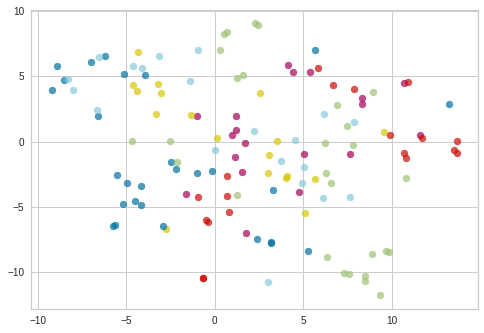

In [ ]:
tsnef = TSNEVisualizer(labels=labellist['label'])
tsnef.fit(xtrain_tfidf,y_train.to_list())
tsnef.show()

In [ ]:
print ("acc: ", res)
# print ("auc: ", metrics.auc(predictions, validation_data_label))
# print ("f1 score: ", metrics.f1_score(predictions, validation_data_label))


**Multiy class**

In [ ]:
# Importing the dependancies
from sklearn import metrics
def metricModel(y_train,y_pred, labels):
  print(metrics.confusion_matrix(y_train, y_pred, labels))
  print(metrics.classification_report(y_train, y_pred, labels))

In [ ]:
# Predicted values
y_pred = ["a", "b", "c", "a", "b","d"]
# Actual values
y_train = ["a", "b", "c", "c", "a","d"]
labels=["a", "b", "c","d"]

metricModel(y_train,y_pred, labels)
